<a href="https://colab.research.google.com/github/hermelawesene/Concrete-Image-Classification-using-Squeeznet-Architecture/blob/main/Squeeznet_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arunrk7/surface-crack-detection")

print("Path to dataset files:", path)

100%|██████████| 233M/233M [00:01<00:00, 169MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1


In [2]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1"
for root, dirs, files in os.walk(dataset_path):
    print(root)
    for file in files[:5]:  # Print first 5 files in each folder
        print("   ", file)


/root/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1
/root/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1/Negative
    05718.jpg
    07457.jpg
    02831.jpg
    09506.jpg
    08296.jpg
/root/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1/Positive
    05718.jpg
    18248_1.jpg
    07457.jpg
    02831.jpg
    09506.jpg


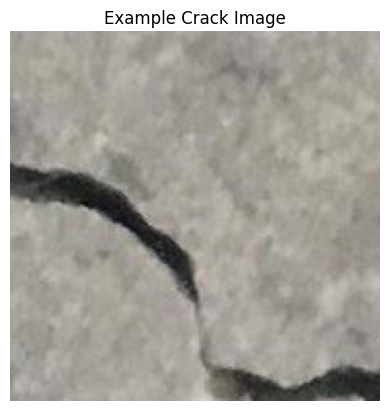

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = os.path.join(dataset_path, "Positive", "16911_1.jpg")
img = Image.open(img_path)

plt.imshow(img)
plt.title("Example Crack Image")
plt.axis('off')
plt.show()


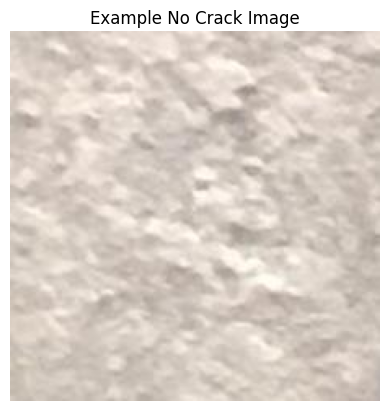

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = os.path.join(dataset_path, "Negative", "05718.jpg")
img = Image.open(img_path)

plt.imshow(img)
plt.title("Example No Crack Image")
plt.axis('off')
plt.show()


In [16]:
# Define constants
IMG_SIZE = 120  # Match original code's resizing
BATCH_SIZE = 128
EPOCHS = 10
DATA_DIR = dataset_path  # Confirmed Kaggle dataset path
LABELS = ['Negative', 'Positive']

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.25,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    label_mode='int',
    shuffle=True
)

Found 40000 files belonging to 2 classes.
Using 30000 files for training.


In [18]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.25,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    label_mode='int',
    shuffle=False
)


Found 40000 files belonging to 2 classes.
Using 10000 files for validation.


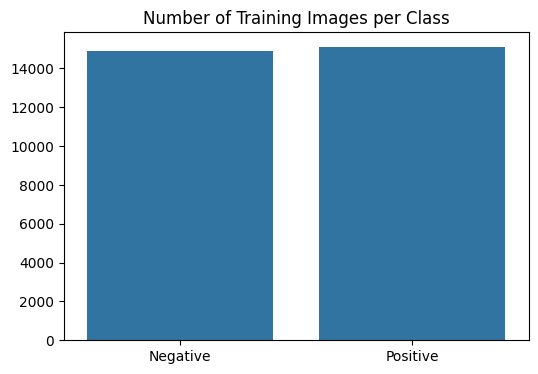

Training counts per class: [14890. 15110.]


In [19]:
import numpy as np
import seaborn as sns
class_counts = np.zeros(2)
for _, labels in train_ds.unbatch():
    class_counts += np.bincount([labels.numpy()], minlength=2)
plt.figure(figsize=(6, 4))
sns.barplot(x=LABELS, y=class_counts)
plt.title("Number of Training Images per Class")
plt.show()
print(f"Training counts per class: {class_counts}")

# newwww

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, ReLU, concatenate, Dropout, GlobalAveragePooling2D, Dense, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def fire_module(x, s1, e1, e3):
    s1x = Conv2D(s1, kernel_size=1, padding='same')(x)
    s1x = ReLU()(s1x)
    e1x = Conv2D(e1, kernel_size=1, padding='same')(s1x)
    e3x = Conv2D(e3, kernel_size=3, padding='same')(s1x)
    x = concatenate([e1x, e3x])
    x = ReLU()(x)
    return x

def SqueezeNet(input_shape=(120, 120, 1), n_classes=1):  # Matches your 120x120 grayscale images
    input = Input(shape=input_shape)

    # Normalize pixel values to [0,1] (matches your previous rescaling)
    x = Rescaling(1./255)(input)

    # Initial layers (adjusted for smaller input size)
    x = Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same')(x)  # Smaller kernel for 120x120
    x = ReLU()(x)
    x = MaxPool2D(pool_size=(3,3), strides=(2,2))(x)

    # Fire modules (reduced filters to match smaller images)
    x = fire_module(x, s1=16, e1=32, e3=32)  # Fire 2
    x = fire_module(x, s1=16, e1=32, e3=32)  # Fire 3
    x = fire_module(x, s1=32, e1=64, e3=64)  # Fire 4
    x = MaxPool2D(pool_size=(3,3), strides=(2,2))(x)

    x = fire_module(x, s1=32, e1=64, e3=64)  # Fire 5
    x = fire_module(x, s1=48, e1=96, e3=96)  # Fire 6
    x = fire_module(x, s1=48, e1=96, e3=96)  # Fire 7
    x = fire_module(x, s1=64, e1=128, e3=128)  # Fire 8
    x = MaxPool2D(pool_size=(3,3), strides=(2,2))(x)

    x = fire_module(x, s1=64, e1=128, e3=128)  # Fire 9

    # Final layers
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D()(x)  # Replaces AvgPool2D(13,13) for dynamic size
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(input, output)
    return model

In [21]:
# Create model
model = SqueezeNet(input_shape=(120, 120, 1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 120, 120,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 60, 60,    │      1,664 │ rescaling_1[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 60, 60,    │          0 │ conv2d_25[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 29, 29,    │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 29, 29,    │      1,040 │ max_pooling2d_3[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 29, 29,    │          0 │ conv2d_26[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 29, 29,    │        544 │ re_lu_18[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 29, 29,    │      4,640 │ re_lu_18[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 29, 29,    │          0 │ conv2d_27[0][0],  │
│ (Concatenate)       │ 64)               │            │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 29, 29,    │          0 │ concatenate_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 29, 29,    │      1,040 │ re_lu_19[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 29, 29,    │          0 │ conv2d_29[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 29, 29,    │        544 │ re_lu_20[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 29, 29,    │      4,640 │ re_lu_20[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 29, 29,    │          0 │ conv2d_30[0][0],  │
│ (Concatenate)       │ 64)               │            │ conv2d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 29, 29,    │          0 │ concatenate_9[0]

 Total params: 362,945 (1.38 MB)

 Trainable params: 362,945 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train using your existing datasets
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
    ]
)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.5415 - loss: 0.6768 - val_accuracy: 0.9711 - val_loss: 0.6869 - learning_rate: 0.0010
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.5807 - loss: 0.6441 - val_accuracy: 0.9920 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9834 - loss: 0.0551 - val_accuracy: 0.9546 - val_loss: 0.1451 - learning_rate: 0.0010
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9893 - loss: 0.0351 - val_accuracy: 0.9986 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9907 - loss: 0.0323 - val_accuracy: 0.9885 - val_loss: 0.0433 - learning_rate: 0.0010
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9935 - loss: 0.0230 - val_accuracy: 0.9832 - val_loss: 0.0555 - learning_rate: 0.0010
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9944 - l

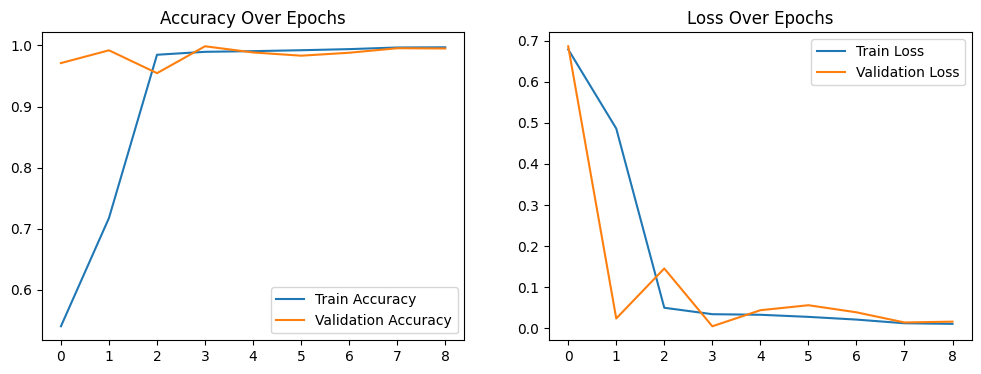

In [23]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()